In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kyky7896","key":"dbe11208a425010496b2ff560a0f5c37"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:15<00:00, 191MB/s]
100% 2.29G/2.29G [00:15<00:00, 161MB/s]


In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
import glob
from PIL import Image
import cv2
from torchsummary import summary

In [ ]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0446-0001.j

In [ ]:
data_dir="./chest/"

In [ ]:
!nvidia-smi

Thu May 26 13:02:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 데이터 불러오기

In [ ]:
# # option 1 : google drive에서 데이터 copy
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp "/content/drive/MyDrive/CNN/Chest.zip" "./"
# !unzip Chest.zip -d chest/
# data_dir = "./chest/"

In [ ]:
# data_dir="../input/chest-xray-pneumonia/"

In [ ]:
## we cal also use the mean and std of ImageNet dataset ie mean=[0.485, 0.456, 0.406] and std =[0.229, 0.224, 0.225]     
train_transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([256,256]),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.3)])
test_trainsform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize([256,256])])

In [ ]:
trainset=datasets.ImageFolder(data_dir + "chest_xray/train/", transform=train_transform)
testset=datasets.ImageFolder(data_dir + "chest_xray/test/",transform=test_trainsform)
valid=datasets.ImageFolder(data_dir + "chest_xray/val/",transform=test_trainsform)

In [ ]:
print(type(trainset), type(testset), type(valid))
print(len(trainset), len(testset), len(valid))

<class 'torchvision.datasets.folder.ImageFolder'> <class 'torchvision.datasets.folder.ImageFolder'> <class 'torchvision.datasets.folder.ImageFolder'>
5216 624 16


In [ ]:
dataset_size = len(trainset)
train_size = int(dataset_size * 0.75)
valid_size = int(dataset_size-train_size)

In [ ]:
trainset, validset = random_split(trainset, [train_size, valid_size])

In [ ]:
validset=valid+validset

In [ ]:

print(type(trainset), len(trainset))
print(type(validset), len(validset))
print(type(testset), len(testset))

<class 'torch.utils.data.dataset.Subset'> 3912
<class 'torch.utils.data.dataset.ConcatDataset'> 1320
<class 'torchvision.datasets.folder.ImageFolder'> 624


In [ ]:
type(trainset[0][0]), type(trainset[0][1])

(torch.Tensor, int)

In [ ]:
# trainset[0][0].size() 
# 1 x 28 x 28 : channels x height x width
# 일반적으로(openCV 등에서는) 이미지가 height x width x channels 로 크기가 표현
# 그러나 파이토치에서는 이미지 한장이 channels x height x width 표시됨을 유의
trainset[0][0].size() # trainset[0][0].shape

torch.Size([3, 256, 256])

## 데이터 시각화

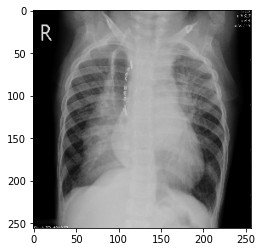

In [ ]:
img = trainset[2][0]
#img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
plt.imshow(img.permute(1, 2, 0))

In [ ]:
trainset[2][1] #0번 : 폐렴아님 , 1번 : 폐렴임

1

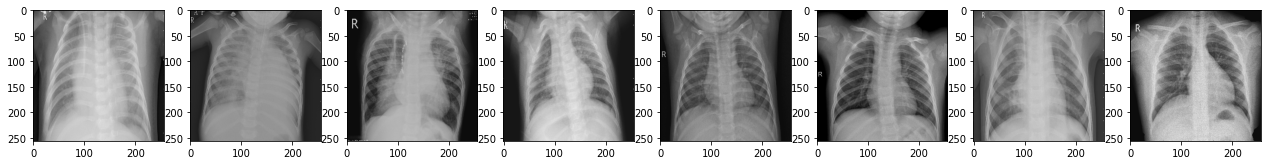

In [ ]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=8)
for i in range(8):
  # axes[i].imshow(trainset[i][0].permute(1, 2, 0))
  img = trainset[i][0]
  #img = img * 0.5 + 0.5 # unnormalize (normalize : (data - 0.5)/0.5))
  axes[i].imshow(img.permute(1, 2, 0))

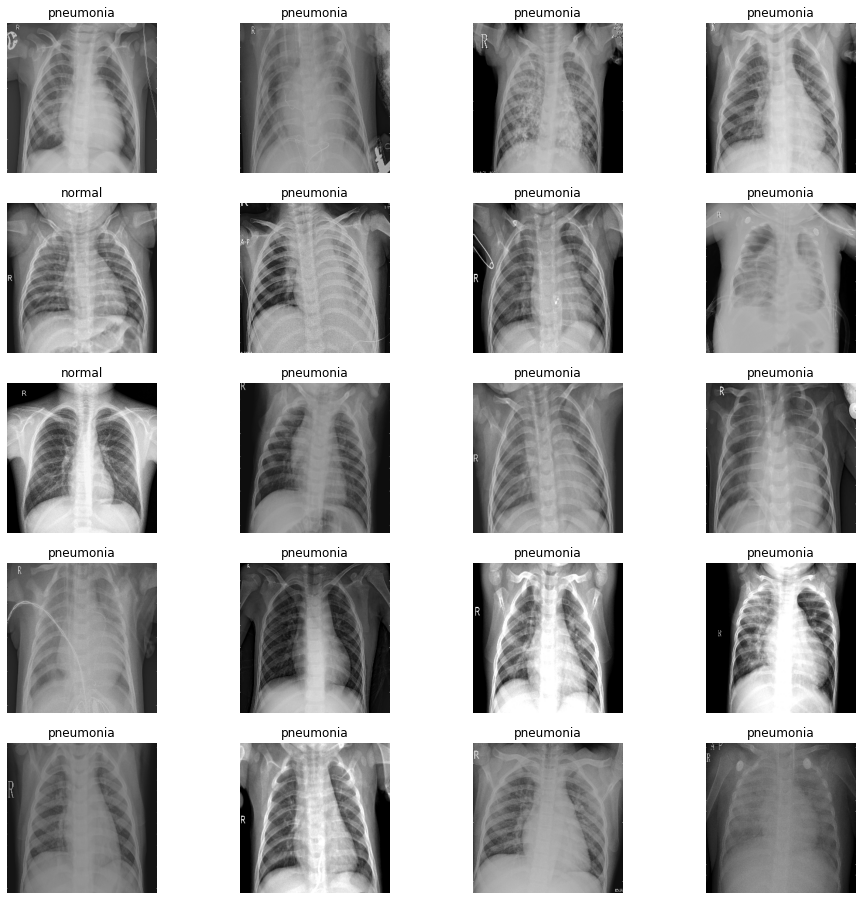

In [ ]:
labels_map = {0 : 'normal', 1 : 'pneumonia'}

fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 5

for i in range(1,columns*rows +1):
  rnd_idx = np.random.randint(len(trainset))
  img = trainset[rnd_idx][0].permute(1, 2, 0) 
  # img = img * 0.5 + 0.5 # unnormalize (normalize : (data - 0.5)/0.5))
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
  # 정답 :trainset[rnd_idx][1] - 정수
  plt.title(labels_map[trainset[rnd_idx][1]])
  plt.axis("off")


## 데이터 적재

In [ ]:
# 파이토치는 데이터를 셔플하거나, 병렬로 데이터를 부르거나,혹은 배치 작업을 
# torch.utils.data.DataLoader 를 통해서 도와줌
batch_size = 16 # 중요한 하이퍼 파라미터, 16 이하로 사용하는것이 성능에 좋다고 알려져 있음
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용

In [ ]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 245
<class 'torch.utils.data.dataloader.DataLoader'> 83
<class 'torch.utils.data.dataloader.DataLoader'> 39


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([16, 3, 256, 256]) torch.Size([16])


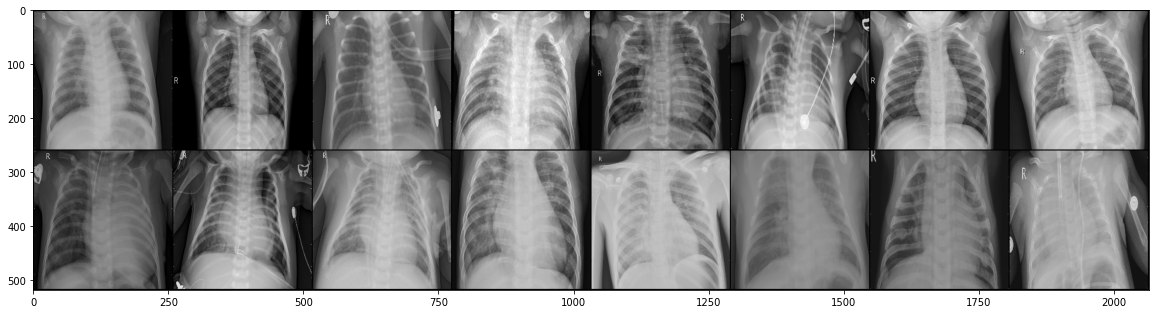

In [ ]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(trainloader)
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

## 모델 생성 (VGGnet)

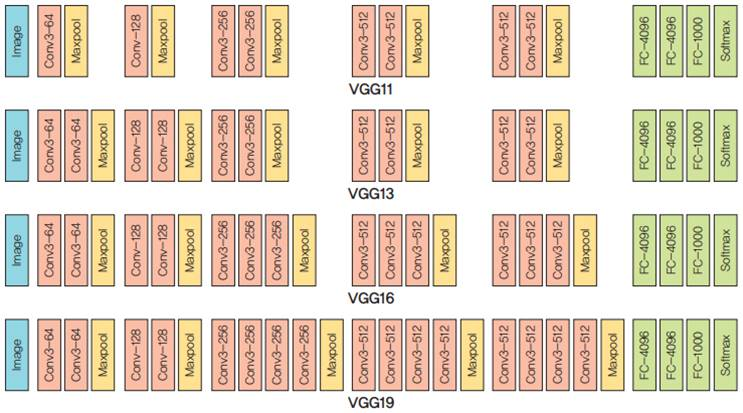

In [ ]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [ ]:
# class VGG16(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.block1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         self.block2 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         self.block3 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(),            
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )    

#         self.block4 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(),            
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )   

#         self.block5 = nn.Sequential(
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(),            
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )  # 512 * 7 * 7
        
#         self.avgpool = nn.AvgPool2d(7, 7)

#         self.classifier = nn.Sequential(            
#             nn.Linear(in_features=512, out_features=64),             
#             nn.LeakyReLU(),                     
#             nn.Dropout(0.3),
#             nn.Linear(in_features=64, out_features=2),            
#         )
       
#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = self.block5(x)
#         x = self.avgpool(x)
#         #x = x.view(-1, 512)
#         x = torch.flatten(x, 1) # 1번 dim부터 펼침
#         x = self.classifier(x)
#         return x
    

In [ ]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=580155ff318b01689eec86d421a493ccad27338433244275fdd35fc86c040c40
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
#모델 생성
efficientNet=EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
model=efficientNet.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

## 모델 컴파일

In [ ]:

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss() # 손실함수
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # 옵티마이저 : Momentum
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001) # 규제의 강도 : weight_decay=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [ ]:
# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# monitoring 하고 있는 값(test_loss)이 patience 기간동안(onPlateau) 줄어들지 않을때  lr에 factor(0.1)를 곱해줌
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=7, factor=0.1, verbose=True)

## 모델 훈련

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def validation(model, testloader, criterion):
#     test_accuracy = 0
    test_loss = 0
    preds_list=[]
    true_list=[]
    
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits.cpu(), dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
#             correct = (preds == labels).sum()
#             accuracy = correct / images.shape[0]
#             test_accuracy += accuracy

   
            labels=labels.cpu()
            preds_list.extend(preds)
            true_list.extend(labels)

        # 평가지표 계산    
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        
                
    return val_accuracy, val_recall, val_f1_score, test_loss


In [ ]:
def train(model, epochs, criterion, optimizer):
    steps = 0
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size
    iter_per_epoch = len(trainloader)
    print_every = iter_per_epoch
    best_f1_score = 0.7

    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = 8 # monitoring 하는 test loss가 더이상 줄지 않는 횟수를 몇번이나 참을지..
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in iter(trainloader): #iterator에서 batch_size씩 가져와 images와 labels에 전달
            steps += 1
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # not Flatten!!
            # images.resize_(images.size()[0], 784)
            optimizer.zero_grad()

            # 1. Forward (Loss 얻게됨)
            output = model.forward(images)
            loss = criterion(output, labels)

            # 2. Backward (Gradient가 오차역전파로 구해짐)
            loss.backward()

            # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
            optimizer.step()
            train_loss += loss.item() # 1 epoch 당 누적된 로스
            if steps % print_every == 0 :
                model.eval() # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
                val_accuracy, val_recall, val_f1_score, val_loss = validation(model, validloader, criterion)
                #train_accuracy, train_recall, train_f1_score, train_loss = validation(model, trainloader, criterion)

                # writer.add_scalar("Loss/train", train_loss/len(trainloader), epoch)
                # writer.add_scalar("Loss/test", valid_loss/len(validloader), epoch)
                # writer.add_scalars("Loss/train and valid",
                #                   { "train" : train_loss/len(trainloader),
                #                     "test" : valid_loss/len(validloader) }, epoch)

                print("Epoch : {}/{}...".format(epoch+1, epochs),
                      " Train Loss : {:.3f}".format(train_loss/len(trainloader) ),
                      " Valid Recall : {:.3f}".format(val_recall),
                      " Valid Accuracy : {:.3f}".format(val_accuracy),
                      " Valid F1_score : {:.3f}".format(val_f1_score)
                      # " Train Recall : {:.3f}".format(train_recall),
                      # " Train Accuracy : {:.3f}".format(train_accuracy),
                      # " Train F1_score : {:.3f}".format(train_f1_score)
                     )
                
                # Best model 저장
                if val_f1_score > best_f1_score:
                    torch.save(model.state_dict(), "best_checkpoint.pth")
                    best_f1_score = val_f1_score

                # Early stopping Start
                if val_loss > min_loss:
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience:
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        # writer.flush()
                        return
                else:
                    min_loss = val_loss
                    trigger = 0
                    # print("min loss set to current valid loss!!!")

                # Early stopping End
                train_loss = 0
                model.train()

                # Learning Rate Scheduler
                scheduler.step(val_loss)
    # writer.flush()

In [ ]:
train(model, 30, criterion, optimizer) 

Epoch : 1/30...  Train Loss : 0.179  Valid Recall : 1.000  Valid Accuracy : 0.756  Valid F1_score : 0.858
Epoch : 2/30...  Train Loss : 0.051  Valid Recall : 0.999  Valid Accuracy : 0.916  Valid F1_score : 0.946
Epoch : 3/30...  Train Loss : 0.039  Valid Recall : 0.977  Valid Accuracy : 0.981  Valid F1_score : 0.987


In [ ]:
# writer.close()

## 평가

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def evaluate(model, testloader):
#     test_accuracy = 0
    test_loss = 0
    preds_list=[]
    true_list=[]
    
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits.cpu(), dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
#             correct = (preds == labels).sum()
#             accuracy = correct / images.shape[0]
#             test_accuracy += accuracy

   
            labels=labels.cpu()
            preds_list.extend(preds)
            true_list.extend(labels)

        # 평가지표 계산    
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        
                
    print("test_accuracy : ", val_accuracy)
    print("test_recall : ", val_recall)
    print("test_f1_score : ", val_f1_score)


In [ ]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
torch.save(model.state_dict(), "last_checkpoint.pth")
state_dict = torch.load("last_checkpoint.pth") 
last_model = model # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
last_model.to(device)
last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
evaluate(last_model, testloader)

In [ ]:
# f1_score 0.7이상 기준으로 가장 높을때의 모델 파라미터가 저장되어 있음
state_dict = torch.load("best_checkpoint.pth") 
best_model = model #모델 넣어주세요
best_model.to(device)
best_model.load_state_dict(state_dict)
evaluate(best_model, testloader)